# CODE-DE/EO-Lab tutorial

<div style="text-align: right"><i> Beginner </i></div>

***
<center><h1> Processing a Vegetation Time Series with FORCE DataCube Collection Data from Jupyter-Lab</h1></center>

***
**General Note 1**: Execute the cells by pressing the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or `Shift` + `Enter`).<br>
<br>
**General Note 2**: If the kernel stops working, in the top MENU, click the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Then, in the top MENU, click "Run" and select "Run All Above Selected Cell".<br>

**General Note 3**: Check out the [**FORUM**](https://forum.code-de.org/en/) or contact support! <br>

***

In this tutorial, we want to use the [FORCE Datacube Collection](https://code-de.org/en/portfolio/?id=0d3fac0e-bee0-4089-95c3-66fc203e801d) without utilizing the [FORCE Processing Environment](https://code-de.org/en/portfolio/?id=7e0e6df5-9d3d-40e9-a158-b0a203965445) itself. The FORCE datacube is described in detail here: https://force-eo.readthedocs.io/en/latest/howto/datacube.html. In the file structure, the atmospherically corrected data using FORCE are already available as BOA (Bottom of Atmosphere) products, along with the cloud masks.

The data using the datacube are further described here: https://force-eo.readthedocs.io/en/latest/components/lower-level/level2/format.html.

To process the data in Python, we need some standard Python libraries, which are imported in the following cell.

In [3]:
#install required libraries
import sys
!{sys.executable} -m pip install numpy 
!{sys.executable} -m pip install rasterio
!{sys.executable} -m pip install boto3
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install pyproj

In [4]:
#import required libraries
import rasterio
from rasterio import plot
import boto3
import os
import numpy as np
import matplotlib.pyplot as plt
from rasterio import plot
from pyproj import Transformer

#somit werden alle Plots im Notebook auf diese Größe definiert. 
plt.rcParams['figure.figsize'] = [12,12]

In [5]:
# access CODE-DE S3 endpoint (setup the keys in the "S3 access credentials" section in your CODE-DE profile)
access_key='<your access key>'
secret_key='<your secret key>'
host='http://data.cloud.code-de.org'
s3=boto3.client('s3',aws_access_key_id=access_key, aws_secret_access_key=secret_key, endpoint_url=host,)
print('Connecting to CODE-DE')

####################

response = s3.list_buckets()

# Überprüfen, ob Buckets vorhanden sind
if 'Buckets' in response:
    # Durch jeden Bucket iterieren und den Namen ausgeben
    print("I found the following buckets:")
    for bucket in response['Buckets']:
        print(bucket['Name'])
else:
    print("No buckets avabiable or no access.")   

Connecting to CODE-DE
I found the following buckets:
CODEDE
EOLAB


FORCE is organized into its own data system: in 30 km x 30 km raster data blocks. These so-called "tiles" are stored in a well-defined projection: https://epsg.io/3035. To know which tile we are in, we need a small function that calculates the correct tile relative to a known tile: here X0044_Y0052.

The two variables in the following cell, `myX` and `myY`, convert the decimal coordinates of our location and calculate "our" FORCE tile. Year and month must also be specified. This defines the "Where" and "When.


In [6]:
# Koordinaten Stadt Bonn: 7.1022/50.7258; Stadt Essen: 7.014761/51.458069
myX = 7.014761
myY = 51.458069

#hier bitte angeben für welches Jahr und Monat gerechnet werden soll:
year='2020'
month='07'

tileSize = 30000

transformer = Transformer.from_crs("EPSG:4326", "EPSG:3035")
y1,x1=transformer.transform(49.992,2.3852)
y2,x2=transformer.transform(myY,myX)
print ("upperleft coordinates of X044 and Y052: ",x1,y1)
print ("my coordinates:", x2,y2)

upperleft coordinates of X044 and Y052:  3776025.3020958267 3014931.1538566556
my coordinates: 4113579.8224517284 3153943.733313543


In [7]:
#x1,y1=reprojectPoint(4326,3035,2.3852,49.992) # upper left coordinate of X0044 und Y0052
#x2,y2=reprojectPoint(4326,3035,myX,myY) #Umprojektion von EPSG:4326 nach EPSG:3035

deltaX= round((x2-x1) / tileSize)
deltaY= round((y2-y1) /tileSize)
tileX='X00'+str(44+deltaX)
tileY='Y00'+str(52-deltaY)
tile=tileX+'_'+tileY
print ("FORCE Tile:", tile)

FORCE Tile: X0055_Y0047


In [11]:
#To look into a certain folder of the the FORCE Data we need a few parameters: tile-x, tile_y and the date
#tile='X0055_Y0047/'
#year='2020'
#month='07'

print ("Suche in:", tile, "/", year, month)

prefix = 'community/FORCE/C1/L2/ard/'+tile+'/'+str(year)+str(month)    
objects = s3.list_objects_v2(Bucket='CODEDE', Prefix=prefix)

print("Seaching for files in the given folder: " + prefix)
files=[]

for obj in objects['Contents']: #for obj in objects['Contents']:
    if '_BOA.tif' in obj['Key']:
        #print(obj['Key'])
        files.append(obj['Key'])
        
print(files)         

Suche in: X0055_Y0047 / 2020 07
Seaching for files in the given folder: community/FORCE/C1/L2/ard/X0055_Y0047/202007
['community/FORCE/C1/L2/ard/X0055_Y0047/20200711_LEVEL2_SEN2B_BOA.tif', 'community/FORCE/C1/L2/ard/X0055_Y0047/20200713_LEVEL2_SEN2A_BOA.tif', 'community/FORCE/C1/L2/ard/X0055_Y0047/20200721_LEVEL2_SEN2B_BOA.tif', 'community/FORCE/C1/L2/ard/X0055_Y0047/20200723_LEVEL2_SEN2A_BOA.tif', 'community/FORCE/C1/L2/ard/X0055_Y0047/20200726_LEVEL2_SEN2A_BOA.tif', 'community/FORCE/C1/L2/ard/X0055_Y0047/20200731_LEVEL2_SEN2B_BOA.tif']


For data processing, we need a cloud mask so that cloudy pixels can be ignored.
For questions about cloud masking in FORCE, this tool might be helpful: https://bit-flag-renderer.readthedocs.io/en/latest/index.html.

In [12]:
def maskCloud(inFile):
  
  src=rasterio.open(inFile)
  out_meta = src.meta
  QA=src.read() << 12
  mask = np.where(((QA > 2**12) ),1,0)
  
  return mask

Now we come to the core of the program. We iterate over all Sentinel-2 scenes, calculate the EVI (or optionally NDVI) for each, mask the clouds, and sum the cloud-free pixels. At the end, we divide by the number of cloud-free pixels to compute the average.

In [13]:
# hier nüssen wir jedes Bild lokal herunterladen:
fLocal = os.path.basename(files[0])
with open(fLocal, 'wb') as data:
        s3.download_fileobj('CODEDE',files[0], data) 

#öffne ein Band um die Metadaten zu lesen
src=rasterio.open(fLocal)
band8=src.read([8])
out_meta = src.meta
src.close() # schliesse das Band wieder
os.remove(fLocal)

#wir legen leere numpy arrays der gleichen Dimensionen an
vi_sum = np.zeros_like(band8, dtype=np.float32)
vi_count = np.zeros_like(band8, dtype=np.uint8)

count=0
for f in files: # Schleife, die über alle Dateien iteriert.
    fLocal = os.path.basename(f)
    with open(fLocal, 'wb') as data:
        s3.download_fileobj('CODEDE',f, data) 
    
    fLocalQA = fLocal.replace('BOA','QAI')
    with open(fLocalQA, 'wb') as data:
        s3.download_fileobj('CODEDE',f.replace('BOA','QAI'), data)
   
    src=rasterio.open(fLocal)
    NIR=src.read([8])/10000.0 # Skalierung in Force: Reflektanz * 10000
    RED=src.read([4])/10000.0
    BLUE = src.read([2])/10000.0
    src.close() 
    
    imgDate=fLocal[0:8]         
    EVI = 2.5*(NIR-RED)/((NIR+6*RED-7.5*BLUE)+1) 
    #Alternativ mit NDVI die beiden folgden Zeilen auskommentieren.. 
    #NDVI = (NIR-RED)/(NIR+RED)
    #EVI = NDVI
    EVI[(EVI >1) | (EVI < -1)] = np.nan
    mask = np.zeros_like(NIR, dtype=np.uint8)
    clouds = maskCloud(fLocalQA) 
    #nodata value in FORCE=-9999  
    mask = np.where((NIR == -9999) | np.isnan(EVI) | (clouds == 1), np.nan, 1)
    # Addition des EVI innerhalb der Schleife               
    vi_sum += np.where(np.isnan(mask), 0, EVI)
    vi_count += np.where(np.isnan(mask), 0, 1).astype(np.uint8)
    count += 1
    print("Processing image: ",count)
    src.close()
    os.remove(fLocal)
    os.remove(fLocalQA)
    
#Summe dividiert durch Anzahl ergibt den Mittelwert. Hier könnte z.B. der Median hilfreich sein.            
vi_average = vi_sum / vi_count


Processing image:  1
Processing image:  2
Processing image:  3
Processing image:  4
Processing image:  5
Processing image:  6


/tmp/ipykernel_2881/1115884584.py:53: RuntimeWarning: invalid value encountered in divide
  vi_average = vi_sum / vi_count


For visualization here in the notebook, we use a simple plot function in pyplot: https://matplotlib.org/stable/tutorials/pyplot.html.

Text(0.5, 1.0, '20200731 - RGB: BLUE, NIR, RED')

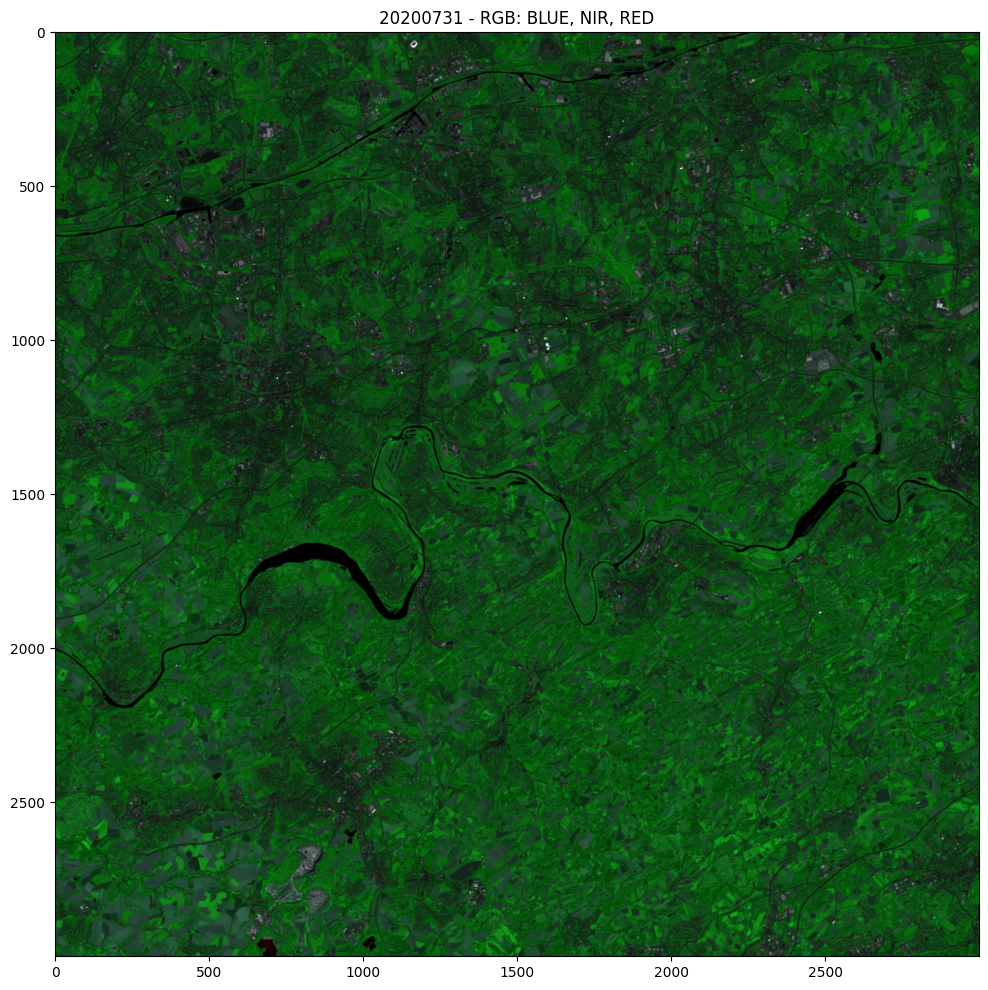

In [14]:
# RGB des letzen Bildes in der Liste
%matplotlib inline
RGB=np.stack([BLUE,NIR,RED],axis=-1).squeeze() 
RGB[(RGB > 1)] = 1
RGB[(RGB < 0)] = 0
plt.imshow(RGB)
plt.title(imgDate + ' - RGB: BLUE, NIR, RED')

The averaged EVI over a month as a composite image of all observations in the month.

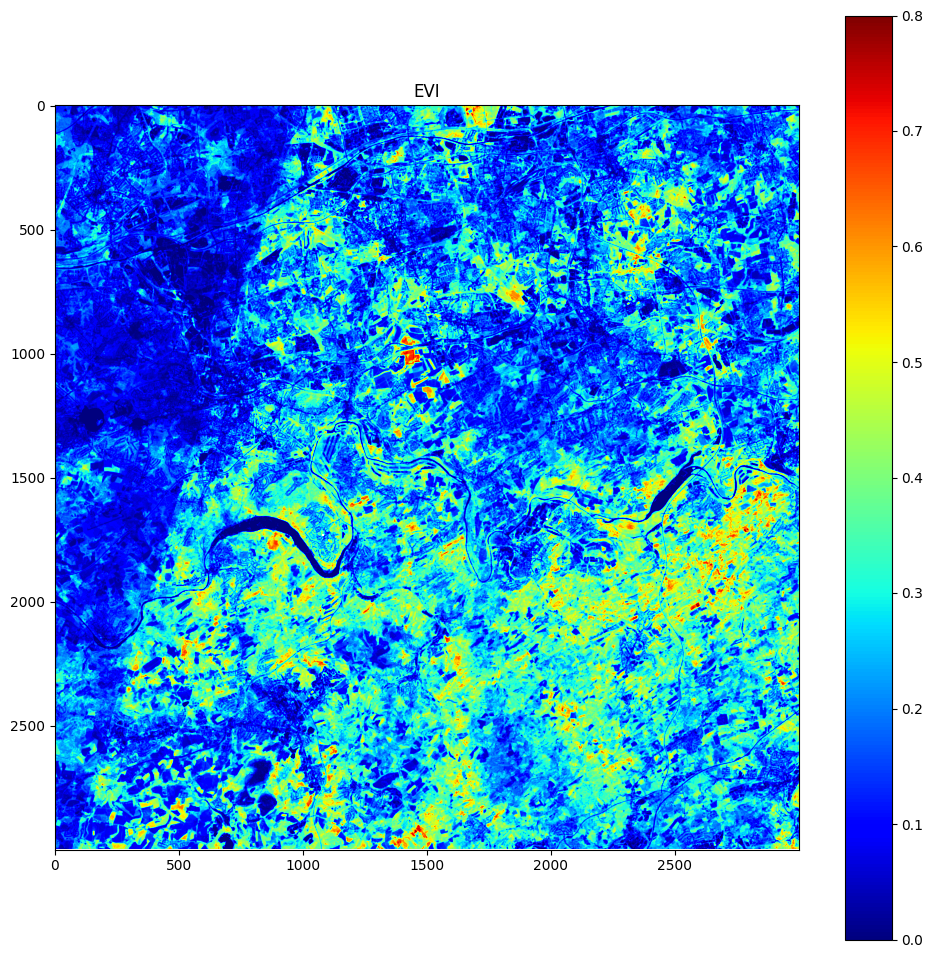

In [15]:
plt.imshow(np.squeeze(vi_average),cmap='jet',vmin=0,vmax=0.8)
plt.title('EVI')
plt.colorbar()

The number of "good" pixels in the image composite as a result of the cloud masking.

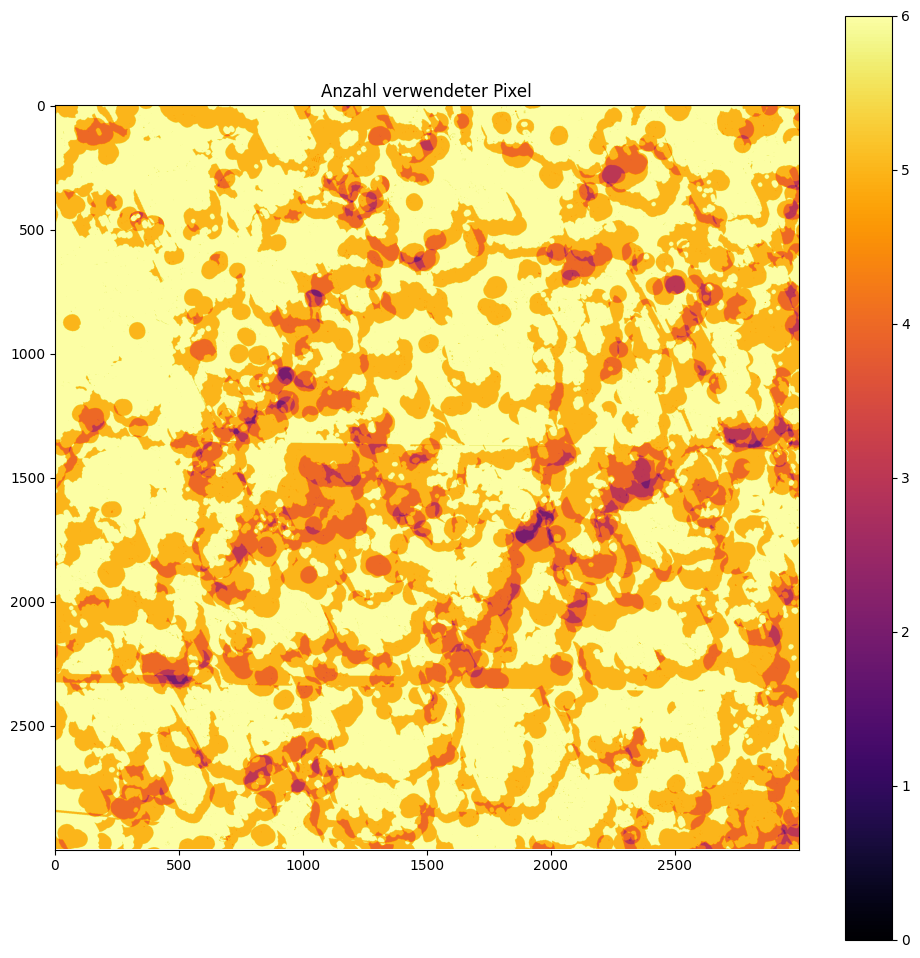

In [16]:
plt.imshow(np.squeeze(vi_count),cmap='inferno',vmin=0,vmax=count)
plt.title('Anzahl verwendeter Pixel')
plt.colorbar()

EVI and the number of "good" pixels are now written as two separate files into the directory and can be, for example, downloaded to the local computer.

In [17]:
kwargs = out_meta
kwargs.update(
    dtype=rasterio.float32,count=1,
    compress='lzw')
with rasterio.open(year+month+'_evi.tif', 'w',**kwargs) as dst:
        dst.write(vi_average.astype(rasterio.float32))
        
#write count image 
kwargs.update(
    dtype=rasterio.uint8,count=1,nodata=255)
with rasterio.open(year+month+'_count.tif', 'w',**kwargs) as dst:
        dst.write(vi_count.astype(rasterio.uint8))